# Attempting some basic aperture photometry (yeet)

Based on method used in previous source detection test

First up, dependencies:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from matplotlib.colors import LogNorm
#from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize

Importing .fits file and extracting the ~ *data* ~:

In [2]:
image_file = 'example_data/PAL5_3p6um.fits'
image_data = fits.getdata(image_file, ext=0)
#print(image_data.shape)

Locating the objects in the image using DAOStarFinder:

In [4]:
mean, median, std = sigma_clipped_stats(image_data, sigma=3.)
daofind = DAOStarFinder(threshold=10.*std, fwhm=1.)
sources = daofind(image_data-median)   # accounting for median bkgd level
#sources = daofind(image_data)
for col in sources.colnames:           # don't need if not printing?
    sources[col].info.format = '%.8g'
print(sources)

 id xcentroid ycentroid sharpness  ... sky    peak       flux       mag    
--- --------- --------- ---------- ... --- ---------- --------- -----------
  1   1269.62 29.760299 0.89393011 ...   0 0.32650128 1.3826189 -0.35175621
  2 1139.9342 29.887711 0.88759232 ...   0 0.30803421  1.352279 -0.32766578
  3 1302.5274  31.64399 0.88821034 ...   0 0.63299173 2.5059827 -0.99744519
  4    800.34 39.843828 0.88167195 ...   0 0.34434986 1.2965169 -0.28194545
  5 1151.3915  42.95208 0.87939498 ...   0  1.2655998 4.3729441  -1.6019348
  6 599.36405 42.654522 0.88928759 ...   0 0.47451913 2.1954421 -0.85380495
  7 388.72005 45.303058 0.88634797 ...   0  5.2755361 23.392756  -3.4227035
  8  435.7022 45.933729 0.88227575 ...   0   1.269724 5.3496495  -1.8208133
  9 1343.9875 45.454981 0.88236197 ...   0  1.8963042 7.5004068   -2.187712
 10 656.35221 49.331316 0.86449988 ...   0 0.58868366 1.8878032 -0.68989181
...       ...       ...        ... ... ...        ...       ...         ...
335 809.6842

Adding the centroid positions of the objects to an array and fitting circular apertures and annuli around them:

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


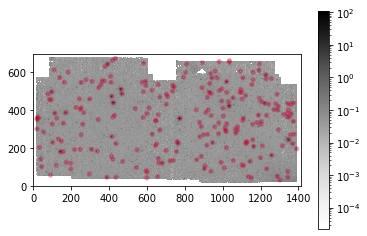

In [5]:
pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
annuli = CircularAnnulus(pos, r_in=8., r_out=12.)
all_apers = [apertures, annuli]
norm = LogNorm()
plt.imshow(image_data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.5)
annuli.plot(color='red', lw=.5, alpha=.5)

#plt.savefig('ap_photom_bkdg_test01.png', dpi=500)

Performing some basic aperture photometry, summing the pixel brightness values (fluxes?) inside each aperture and annulus:

(Note: 'nan' values for apertures could be where the objects are too close to the edge of the image and use some pure white in their summation, and those for the annuli might be where annuli overlap?)

In [6]:
phot_table = aperture_photometry(image_data, all_apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1 1302.5274  31.64399      22.667446      36.651749
  2 1151.3915  42.95208      33.065197      16.222132
  3 599.36405 42.654522      11.114953            nan
  4 388.72005 45.303058      77.353987            nan
  5  435.7022 45.933729      23.852525            nan
  6 1343.9875 45.454981      38.275833      25.622484
  7 656.35221 49.331316       17.29371      13.891394
  8 1135.1498 49.438358      15.938834       14.84867
  9 1289.1213 51.213269      70.329249      27.648923
 10 90.235315 57.316591            nan            nan
...       ...       ...            ...            ...
227 393.08604 643.61014      240.09919      23.432584
228 809.68427 644.34914       13.00091      14.689237
229 1195.4004 645.28914      11.547058      10.161244
230 582.23672 649.46123      38.351931       11.82468
231 891.17372 650.97896     

Finding which star coordinates are giving me attitude:

In [7]:
fail_test_x_ap = []
fail_test_y_ap = []
fail_test_x_an = []
fail_test_y_an = []

for i in range(0, 236):
    if np.isnan(phot_table['aperture_sum_0'][i]) == True:
        fail_test_x_ap.append(phot_table['xcenter'][i])
        fail_test_y_ap.append(phot_table['ycenter'][i])
    if np.isnan(phot_table['aperture_sum_1'][i]) == True:
        fail_test_x_an.append(phot_table['xcenter'][i])
        fail_test_y_an.append(phot_table['ycenter'][i])

print(fail_test_x_ap)
print(fail_test_y_ap)
print(fail_test_x_an)
print(fail_test_y_an)

# This next bit assumes the funky outputs are strings, which they're not :(

#x_please = []
#for i in range(0, len(fail_test_x_ap)):
#    x_please.append(re.findall('\d+\.\d+', fail_test_x_ap[i]))

win_test_x_ap = [90.23531529, 1390.76042064, 18.58390507, 19.48460462, 19.52340405, 981.34715259, 1035.73867482, 433.14706338]
win_test_y_ap = [57.31659113, 196.05943757, 301.46410181, 351.22961332, 359.77481255, 656.86999374, 661.42429926, 674.00142684]
win_test_all_ap = np.column_stack((win_test_x_ap, win_test_y_ap))

win_test_x_an = [599.36405336, 388.72004555, 435.70219801, 90.23531529, 1390.76042064, 18.58390507, 19.48460462, 26.76140825, 19.52340405, 891.17371938, 981.34715259, 1034.57325749, 1035.73867482, 433.14706338]
win_test_y_an = [42.65452201, 45.3030576, 45.93372855, 57.31659113, 196.05943757, 301.46410181, 351.22961332, 359.49858857, 359.77481255, 650.97896271, 656.86999374, 654.45525224, 661.42429926, 674.00142684]
win_test_all_an = np.column_stack((win_test_x_an, win_test_y_an))

aperture_fails = CircularAperture(win_test_all_ap, r=10.)
annulus_fails = CircularAnnulus(win_test_all_an, r_in=20., r_out=30.)

[90.23531529329756, 1390.7604206351923, 18.58390507101269, 19.484604621197274, 19.523404049831043, 981.3471525866872, 1035.7386748248332, 433.1470633827911]
[57.316591133681655, 196.05943756602232, 301.46410181232125, 351.22961331937745, 359.7748125517764, 656.8699937414337, 661.424299264032, 674.0014268383811]
[599.364053360778, 388.7200455498556, 435.70219800546386, 90.23531529329756, 1390.7604206351923, 18.58390507101269, 19.484604621197274, 26.761408245305557, 19.523404049831043, 891.1737193763081, 981.3471525866872, 1034.5732574938138, 1035.7386748248332, 433.1470633827911]
[42.65452201493125, 45.30305759675235, 45.93372854665834, 57.316591133681655, 196.05943756602232, 301.46410181232125, 351.22961331937745, 359.4985885748719, 359.7748125517764, 650.9789627055499, 656.8699937414337, 654.4552522362272, 661.424299264032, 674.0014268383811]


Plotting apertures around problem stars:

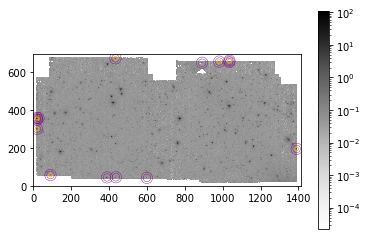

In [8]:
plt.imshow(image_data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
aperture_fails.plot(color='orange', lw=.7, alpha=1.)
annulus_fails.plot(color='purple', lw=.4, alpha=1.)

#plt.savefig('ap_photom_fail_stars_02.png', dpi=500)

Estimating the local background in the annuli by finding the mean brightness within:

In [9]:
bkg_mean = phot_table['aperture_sum_1'] / annuli.area
bkg_sum = bkg_mean * apertures.area
final_sum = phot_table['aperture_sum_0'] - bkg_sum

phot_table['residual_sum_mean'] = final_sum
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1 residual_sum_mean
       pix       pix                                                   
--- --------- --------- -------------- -------------- -----------------
  1 1302.5274  31.64399      22.667446      36.651749         6.1741586
  2 1151.3915  42.95208      33.065197      16.222132         25.765238
  3 599.36405 42.654522      11.114953            nan               nan
  4 388.72005 45.303058      77.353987            nan               nan
  5  435.7022 45.933729      23.852525            nan               nan
  6 1343.9875 45.454981      38.275833      25.622484         26.745715
  7 656.35221 49.331316       17.29371      13.891394         11.042583
  8 1135.1498 49.438358      15.938834       14.84867         9.2569327
  9 1289.1213 51.213269      70.329249      27.648923         57.887234
 10 90.235315 57.316591            nan            nan               nan
...       ...       ...            ...            ...           

Alternate method: better stats yay (sigma-clipped median in the annuli):

In [10]:
annulus_masks = annuli.to_mask(method='center') # note: exact would be overkill for local bkg estimation (read ap phot tutorial for explanation)

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(image_data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
phot = aperture_photometry(image_data, apertures)
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * apertures.area
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']

for col in phot.colnames:
    phot[col].info.format = '%.8g'
print(phot)

 id  xcenter   ycenter  aperture_sum annulus_median  aper_bkg aper_sum_bkgsub
       pix       pix                                                         
--- --------- --------- ------------ -------------- --------- ---------------
  1 1302.5274  31.64399    22.667446     0.13898774 15.719143       6.9483022
  2 1151.3915  42.95208    33.065197    0.062025705  7.014942       26.050255
  3 599.36405 42.654522    11.114953    0.049962457 5.6506208       5.4643322
  4 388.72005 45.303058    77.353987    0.066869229 7.5627316       69.791255
  5  435.7022 45.933729    23.852525    0.056585422 6.3996604       17.452865
  6 1343.9875 45.454981    38.275833     0.10151056 11.480574       26.795259
  7 656.35221 49.331316     17.29371    0.053596228 6.0615906        11.23212
  8 1135.1498 49.438358    15.938834    0.057368886 6.4882681       9.4505658
  9 1289.1213 51.213269    70.329249     0.10606985 11.996217       58.333032
 10 90.235315 57.316591          nan    0.050021626 5.6573126   

In [11]:
f = open('file.txt', 'wb')
for col in phot.colnames:
    f.write(phot[col])